# Laurie Cagney - Fanfiction Text Analysis

- Last modified: 2021-06-19

## Introduction

The purpose of this project is to examine fanfiction text and perform topic modeling to understand what the most popular authors are writing about.  For this project, I chose to focus on one fandom: Doctor Who. 

<b>Datasource Details</b>

Archive of Our Own (https://archiveofourown.org) is a volunteer run repository for fans to post fanworks about their favorite content. It is owned by the Organization of Transformative Works. It is organized by different fandoms, which is collection of people who are the fans of a particular person, series, character etc. The Doctor Who fandom refer to themselves as "Whovians".

<b>Dataset Details</b>

- Scraped 05/07/2021
- Fics rated Teen and Below
- Completed Fics
- Sorted by the ones with the most "Kudos" (votes given by users)
- Metadata from 1400 fics including the text of each chapter 1

<b>Outline</b>

- Load Required Libraries & Dataset
- Explore Data
- Clean Fic Text
    - Stemming
    - Lemmatization
    - Nouns Only
- Word Cloud, BiGrams, TriGrams
- LDA
- Model Tuning
- Explore Topics
- Classify A New Fic
- References

### Load Libraries & Dataset

In [1399]:

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import html

import nltk as nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
import numpy as np
from PIL import Image, ImageOps

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV

import gensim
from gensim import corpora

from datetime import date

In [949]:
#Cleaned files for when I need to shut workbook down

#fic_reduced_lem = pd.read_csv('/Users/lcags/Documents/Practicum1/fic_reduced_clean_lem_2021-05-28.csv')
#fic_reduced_stem = pd.read_csv('/Users/lcags/Documents/Practicum1/fic_reduced_clean_stem_2021-05-28.csv')
#fic_lem_noun = pd.read_csv('/Users/lcags/Documents/Practicum1/fic_lem_nounonly_tokens_2021-05-28.csv')

Load data. This data was scraped using a prebuilt scraper from: https://github.com/radiolarian/AO3Scraper

I modified the scraper to bring back less columns and there were two bugs that needed to be updated but other than that I kept the script as is. It was built to adhere to Ao3's TOS so I wanted to make sure I followed that.

In [959]:
#Load dataset
fic_raw= pd.read_csv('/Users/lcags/Documents/Practicum1/AO3Scraper/DoctorWho_Fics.csv')

In [1382]:
#View first couple rows to ensure data loaded ok
fic_raw.head()

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits,body
0,4148136,Of Wizards and Heroes,['storyforsomeone'],Teen And Up Audiences,M/M,"Harry Potter - J. K. Rowling, The Avengers (Ma...",Loki (Marvel)/Harry Potter,"Harry Potter, Tony Stark, Natasha Romanov, Cli...","Crossover, Powerful Harry, Tony Stark Needs a ...",English,2015-06-16,Completed,2016-01-03,92331,22/22,1911.0,19933,6376.0,395605,As I myself often listen to music whilst I rea...
1,10608267,Someday You're Going to Realize (that I'm pass...,['dls'],General Audiences,Gen,"Marvel Cinematic Universe, Daredevil (TV), Ele...",Tony Stark & Avengers Team,"Tony Stark, James ""Rhodey"" Rhodes, Hope Van Dy...","Post-Captain America: Civil War (Movie), Civil...",English,2017-04-13,Completed,2017-04-13,5280,1/1,437.0,8467,1737.0,117752,\nOne.\n\n\nSam hadn't wanted the dubious hono...
2,344392,The Boy Who Waited,['Lunik'],Not Rated,Gen,"Doctor Who (2005), Thor (2011), The Avengers (...",NaN,"Auton Rory Williams, Phil Coulson, Avengers - ...","World without stars, Amnesia, Community: norse...",English,2012-02-21,Completed,2012-02-21,6747,6/6,190.0,4569,1343.0,47356,"""Maybe you should let the English kid talk to ..."
3,12292116,My Fandom Needs Me,['Riv_ika'],Teen And Up Audiences,"F/M, Multi, M/M, Other, F/F, Gen","Marvel Cinematic Universe, The Avengers (Marve...","Tony Stark/Reader, Tony Stark & Reader, Legola...","Tony Stark, Legolas Greenleaf, Tom Hiddleston,...","XReader, one shots, collection, Reader-Insert,...",English,2017-10-07,Completed,2020-10-16,227340,163/163,679.0,3789,276.0,122502,Hey there! Welcome to my collection of One-Sho...
4,609625,Past Tense,['Try2CatchMe'],Teen And Up Audiences,Gen,"Supernatural, Doctor Who",NaN,"Dean Winchester, Sam Winchester, Tenth Doctor",Superwho,English,2012-12-26,Completed,2012-12-26,6851,1/1,191.0,3700,625.0,60723,"Dean swallows around his tongue, which suddenl..."


In [4]:
#View total dimensions
fic_raw.shape

(1400, 20)

1400 rows by 20 columns of data.

### Explore Numeric Data

Several descriptive fields were scraped as part of this dataset. The following code seeks to understand what the distribution of the different fields looks like.


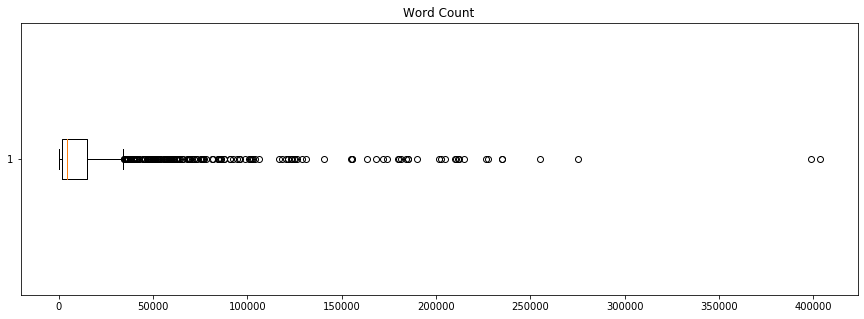

In [1482]:
fig = plt.figure(figsize =(15, 5))
plt.boxplot(fic_raw.words, vert = 0)

plt.title('Word Count')
plt.show()


Lots of outliers in terms of length, two of the stories have over 400k words! This was why I was hesitant about scraping an entire story versus just chapter ones. The important words might've gotten biased towards the stories with more words. This could also go into the next version of this topic modeling using a more balanced version of this dataset. 

Text(0.5, 1.0, 'Number of Words')

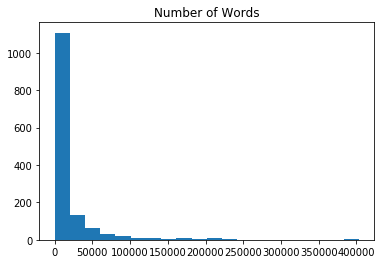

In [1470]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(fic_raw.words, bins = 20)
plt.title('Number of Words')


Text(0.5, 1.0, 'Number of Comments')

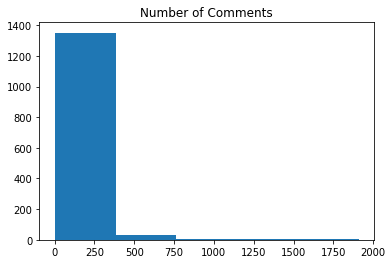

In [883]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(fic_raw.comments, bins = 5)
plt.title('Number of Comments')

Text(0.5, 1.0, 'Number of Kudos')

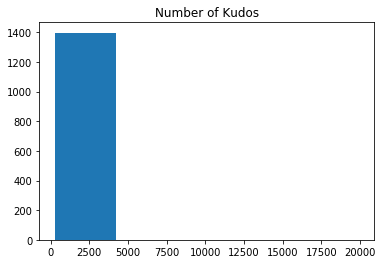

In [885]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(fic_raw['kudos'], bins = 5)
plt.title('Number of Kudos')

Text(0.5, 1.0, 'Number of Hits')

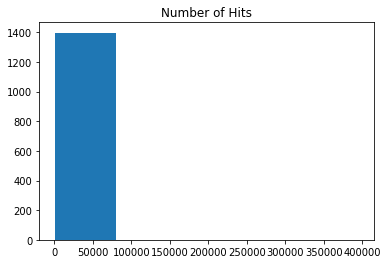

In [887]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(fic_raw.hits, bins = 5)
plt.title('Number of Hits')

It looks like there is a a group of fics that have a LOT of comments, hits, etc and then it drops off in true popularity. Using describe, I can see the mean versus the median and confirm.

In [1381]:
fic_raw.describe()

,work_id,words,comments,kudos,bookmarks,hits
count,1.400000e+03,1400.000000,1396.000000,1400.000000,1397.000000,1400.000000
mean,9.950502e+06,17571.670000,79.966332,501.610714,69.993558,6015.800000
std,7.823156e+06,36792.863873,158.756077,664.650427,194.664900,12629.891235
min,4.915000e+03,6.000000,1.000000,258.000000,1.000000,653.000000
25%,1.898000e+06,1999.000000,17.000000,301.000000,27.000000,2854.500000
50%,9.346382e+06,4322.000000,35.000000,368.000000,43.000000,4112.500000
75%,1.664361e+07,15013.750000,72.000000,513.250000,70.000000,6180.250000
max,2.833252e+07,403206.000000,1911.000000,19933.000000,6376.000000,395605.000000


In [1471]:
#How many fics have less than 90000 words?
fic_raw.work_id[fic_raw.words>90000].count()

57

In [598]:
#How many fics have less than 1000 words?
fic_raw.work_id[fic_raw.words<1000].count()

102

In [1483]:
#How many are outside of the 75th percentile
fic_raw.work_id[fic_raw.words>15013].count()

350

There is a pretty big disparity between the mean and median for popularity indicators. This doesn't matter for the purposes of this project but maybe a future iteration can look at the components that comprise of popular.

In [1394]:
fic_raw['published']= pd.to_datetime(fic_raw['published'])
pub_dates = fic_raw["published"].groupby(fic_raw.published.dt.year).agg('count')

In [1404]:
pd.set_option('display.max_rows',20)
pub_dates

published
2007      4
2008     11
2009     11
2010     28
2011     44
2012     69
2013    114
2014    151
2015    131
2016    128
2017    161
2018    275
2019    151
2020    122
Name: published, dtype: int64

The bulk of the most popular fics were published >2013.

In [890]:
#Rating Groups
fic_raw['rating'].value_counts()

Teen And Up Audiences    712
General Audiences        613
Not Rated                 75
Name: rating, dtype: int64

In [891]:
#Relationship Pairings
fic_raw['relationship'].value_counts()

Tenth Doctor/Rose Tyler                                                                                      187
Thirteenth Doctor/Yasmin Khan                                                                                 52
Thirteenth Doctor/River Song                                                                                  34
The Doctor/River Song, Thirteenth Doctor/River Song                                                           27
Eleventh Doctor/River Song, The Doctor/River Song                                                             23
                                                                                                            ... 
Eleventh Doctor/Rose Tyler, Eleventh Doctor & River Song                                                       1
Draco Malfoy/Harry Potter, Harry Potter/Severus Snape, Harry Potter/Voldemort, Lucius Malfoy/Harry Potter      1
Amy Pond/Rory Williams, Eleventh Doctor/Rose Tyler                                              

In [1543]:
ships = fic_raw['relationship'].str.split(",").explode().reset_index(drop=True)

ships = pd.DataFrame(ships, columns = ['relationship'])
#ships['relationship'].value_counts()

In [1541]:
#Export to CSV
ships.to_csv(r'/Users/lcags/Documents/Practicum1/ships.csv'
                        ,index = False
                        , header=True)

### Cleaning

This next sections iterates through different versions of cleaning: stemming, lemmatizing, and nouns only lemmatized.

In [1405]:
fic_raw.isnull().sum()

work_id              0
title                0
author               0
rating               0
category            41
fandom               0
relationship       112
character           24
additional tags    153
language             0
published            0
status               0
status date          0
words                0
chapters             0
comments             4
kudos                0
bookmarks            3
hits                 0
body                 0
dtype: int64

There are nulls but not in any of the columns I will use. 

In [391]:
#Reduce dataset to just ID, Title, and Body 

fic_reduced = fic_raw[['work_id','title','body']]

In [392]:
#View first couple rows
fic_reduced.head()

,work_id,title,body
0,4148136,Of Wizards and Heroes,As I myself often listen to music whilst I rea...
1,10608267,Someday You're Going to Realize (that I'm pass...,\nOne.\n\n\nSam hadn't wanted the dubious hono...
2,344392,The Boy Who Waited,"""Maybe you should let the English kid talk to ..."
3,12292116,My Fandom Needs Me,Hey there! Welcome to my collection of One-Sho...
4,609625,Past Tense,"Dean swallows around his tongue, which suddenl..."


In [394]:
fic_reduced_cleanHTML = fic_reduced.copy()
#Remove HTML characters
fic_reduced_cleanHTML.body = html.unescape(fic_reduced.body)

In [396]:
#Remove \n characters
fic_reduced_cleanEscape = fic_reduced_cleanHTML.copy()
fic_reduced_cleanEscape.body = fic_reduced_cleanHTML.body.replace('\n', '', regex=True)


In [1409]:
stopwords = stopwords.words('english')

In [1413]:
#stem words
root = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
#lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()


In [345]:
#Function to clean the text and stem it
def clean_text_stemming(text):
    tokens = word_tokenize(text)
    tokens_lower = [w.lower() for w in tokens]
    tokens_alpha = [w for w in tokens_lower if w.isalpha()]
    tokens_stopwords = [w for w in tokens_alpha if not w in stopwords]
    tokens_stem = [root(w) for w in tokens_stopwords]
    
    final =' '.join(tokens_stem)
    return final

In [363]:
#Function to clean text and lemmatize
def clean_text_lemmatizer(text):
    tokens = word_tokenize(text)
    tokens_lower = [w.lower() for w in tokens]
    tokens_alpha = [w for w in tokens_lower if w.isalpha()]
    tokens_stopwords = [w for w in tokens_alpha if not w in stopwords]
    tokens_lemm = [lemmatizer.lemmatize(w) for w in tokens_stopwords]
    
    final =' '.join(tokens_lemm)
    return final

In [347]:
#Prior to cleaning
fic_reduced

,work_id,title,body
0,4148136,Of Wizards and Heroes,As I myself often listen to music whilst I rea...
1,10608267,Someday You're Going to Realize (that I'm pass...,One.Sam hadn't wanted the dubious honor of gua...
2,344392,The Boy Who Waited,"""Maybe you should let the English kid talk to ..."
3,12292116,My Fandom Needs Me,Hey there! Welcome to my collection of One-Sho...
4,609625,Past Tense,"Dean swallows around his tongue, which suddenl..."
...,...,...,...
1395,14497917,Star Crossed,It was late autumn when the star senior of the...
1396,5206328,He Gave Me the World,"""Love looks not with the eyes, but with th..."
1397,1506440,Responsibility,"She hasn't seen him for months. Six months, an..."
1398,12862200,Happy Endings,Travelling the universe with Heather was amazi...


In [399]:
#Create stemmed
fic_reduced_stem = fic_reduced_cleanEscape.copy()
fic_reduced_stem.body = fic_reduced_stem.body.apply(clean_text_stemming)

In [407]:
#Create lemmatized
fic_reduced_lem = fic_reduced_cleanEscape.copy() 
fic_reduced_lem.body = fic_reduced_lem.body.apply(clean_text_lemmatizer)

In [412]:
#View Stemmed
fic_reduced_stem

,work_id,title,body
0,4148136,Of Wizards and Heroes,often listen music whilst read write notic inc...
1,10608267,Someday You're Going to Realize (that I'm pass...,want dubiou honor guard stark one air support ...
2,344392,The Boy Who Waited,mayb let english kid talk coulson glanc file t...
3,12292116,My Fandom Needs Me,hey welcom collect know want get chapter make ...
4,609625,Past Tense,dean swallow around tongu suddenli feel dri sw...
...,...,...,...
1395,14497917,Star Crossed,late autumn star senior physic depart john nob...
1396,5206328,He Gave Me the World,love look eye mind therefor wing cupid paint b...
1397,1506440,Responsibility,seen month six month know exact date without c...
1398,12862200,Happy Endings,travel univers heather need tardi get anywher ...


In [413]:
#View lemmatized
fic_reduced_lem

,work_id,title,body
0,4148136,Of Wizards and Heroes,often listen music whilst read write notice in...
1,10608267,Someday You're Going to Realize (that I'm pass...,wanted dubious honor guarding stark one air su...
2,344392,The Boy Who Waited,maybe let english kid talk coulson glanced fil...
3,12292116,My Fandom Needs Me,hey welcome collection know want get chapter m...
4,609625,Past Tense,dean swallow around tongue suddenly feel dry s...
...,...,...,...
1395,14497917,Star Crossed,late autumn star senior physic department john...
1396,5206328,He Gave Me the World,love look eye mind therefore winged cupid pain...
1397,1506440,Responsibility,seen month six month know exact date without c...
1398,12862200,Happy Endings,travelling universe heather need tardis get an...


### Only nouns 

After working through the first iterations of the topic modeling, I decided that a noun only version would be useful.

In [870]:
def noun_only(text):
    tokenized = word_tokenize(text)
    nouns = [word for (word, pos) in pos_tag(tokenized) if pos in ['NN']] 
    final = ' '.join(nouns)
    return final


In [1407]:
test = "clara waved him over to the car"

noun_only(test)


'clara car'

In [ ]:
#Noun only cleaning
fic_lem_noun = fic_reduced_lem.copy()
fic_lem_noun.body = fic_lem_noun.body.apply(noun_only)

Export cleaned text to CSV so I don't have to run code to clean it continuously since it took several minutes at each step.

In [1267]:
today = str(date.today())

In [403]:
fic_reduced_stem.to_csv(r'/Users/lcags/Documents/Practicum1/fic_reduced_clean_stem_' +today+'.csv'
                        ,index = False
                        , header=True)

In [410]:
fic_reduced_lem.to_csv(r'/Users/lcags/Documents/Practicum1/fic_reduced_clean_lem_'+today+'.csv'
                       ,index = False
                       ,header=True)

In [416]:
fic_lem_noun.to_csv(r'/Users/lcags/Documents/Practicum1/fic_lem_nounonly_tokens_'+today+'.csv'
                    ,index = False
                    ,header=True)

Created flattened version of the files with all the words combined together. This will make it easier to get the word counts and word clouds.

In [425]:
fic_lem_flatten = ' '.join(fic_reduced_lem['body'])

In [426]:
fic_stem_flatten = ' '.join(fic_reduced_stem['body'])

In [900]:
noun_flatten = ' '.join(fic_lem_noun['body'])

In [ ]:
fic_reduced_stem

<h2> Word Clouds - Stemmed</h2>
    
This next section will look at word clouds of the most common individual words, bigrams, and trigrams. It will also split out the parts of speech to further split the data. 

In [427]:
retokenize = word_tokenize(fic_stem_flatten)

In [433]:
retokenize[:10]

['often',
 'listen',
 'music',
 'whilst',
 'read',
 'write',
 'notic',
 'includ',
 'soundtrack',
 'suggest']

In [434]:
mostcommon = FreqDist(retokenize)

In [438]:
#What are the top 10 words?
mostcommon.most_common(10)

[('doctor', 202441),
 ('rose', 171629),
 ('look', 108066),
 ('said', 103715),
 ('back', 92332),
 ('like', 84354),
 ('time', 82311),
 ('could', 82210),
 ('one', 73866),
 ('would', 71637)]

In [439]:
wc = WordCloud(background_color ="White")
img = wc.generate_from_frequencies(mostcommon)

(-0.5, 399.5, 199.5, -0.5)

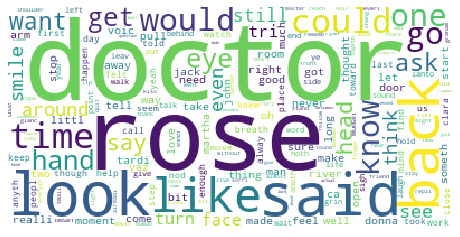

In [440]:
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")


<h2>Bigrams</h2>

In [442]:
cv = CountVectorizer(ngram_range=(2,2))
counts = cv.fit_transform([fic_stem_flatten])

In [443]:
bgnames = []
bgcounts = []
for w in cv.get_feature_names(): bgnames.append(w)
for c in counts.toarray().flatten(): bgcounts.append(c)
bigrams = pd.DataFrame({'word':bgnames,'count':bgcounts})

In [757]:
topBigrams = bigrams.sort_values(ascending=False,by="count")[:25]

In [244]:
topBigrams

,word,count
947177,doctor said,10014
3662565,time lord,9231
3129410,shook head,9099
2942090,rose said,8586
741746,could see,4877
2943670,rose tyler,4789
1985037,let go,4755
2936431,rose asked,4746
1470444,gon na,4674
1269336,first time,4143


In [450]:
wc_bigram = WordCloud(background_color="white").generate_from_frequencies(frequencies=dict(bigrams.values))

(-0.5, 399.5, 199.5, -0.5)

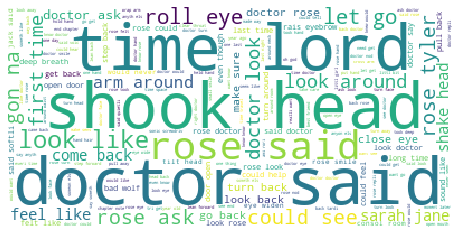

In [451]:
plt.figure(figsize=(8,6))
plt.imshow(wc_bigram)
plt.axis("off")

<h3>Trigram</h3>

In [452]:
cv_tri = CountVectorizer(ngram_range=(3,3))
counts_tri = cv_tri.fit_transform([fic_stem_flatten])

In [454]:
tgnames = []
tgcounts = []
for w in cv_tri.get_feature_names(): tgnames.append(w)
for c in counts_tri.toarray().flatten(): tgcounts.append(c)
trigrams = pd.DataFrame({'word':tgnames,'count':tgcounts})

In [455]:
wc_trigram = WordCloud(background_color="white").generate_from_frequencies(frequencies=dict(trigrams.values))

(-0.5, 399.5, 199.5, -0.5)

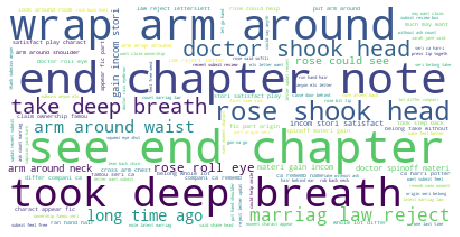

In [456]:
plt.figure(figsize=(8,6))
plt.imshow(wc_trigram)
plt.axis("off")

In [758]:
topTrigrams = trigrams.sort_values(ascending=False,by="count")[:20]

In [759]:
 topTrigrams

,word,count
7310917,see end chapter,1985
2373729,end chapter note,1984
9786522,wrap arm around,1898
8880754,took deep breath,1723
6994875,rose shook head,1043
2116131,doctor shook head,909
8405247,take deep breath,782
5154971,marriag law reject,726
382839,arm around waist,645
4874161,long time ago,555


<h2>Image</h2>

(-0.5, 899.5, 1279.5, -0.5)

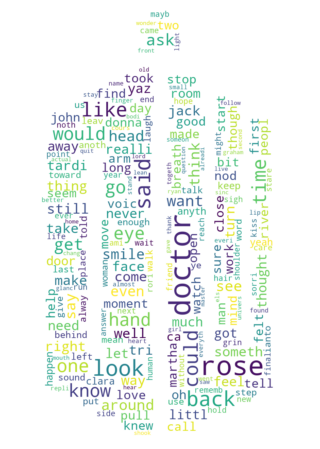

In [460]:
dw_mask = np.array(Image.open("/Users/lcags/Documents/Practicum1/DoctorWhoLogo.png"))

    
dw_wc = WordCloud(mask=dw_mask, background_color = "White").generate_from_frequencies(mostcommon)
plt.figure(figsize=(10,8))
plt.imshow(dw_wc, interpolation='bilinear')
plt.axis('off')

### Words Clouds - Lemmatizer

In [462]:
fic_lem_flatten  = ' '.join(fic_reduced_lem['body'])

In [463]:
retokenize_lem = word_tokenize(fic_lem_flatten)

In [225]:
mostcommon_lem = FreqDist(retokenize_lem)

In [464]:
mostcommon_lem.most_common(25)

[('doctor', 202338),
 ('rose', 171626),
 ('said', 103715),
 ('back', 91061),
 ('could', 82210),
 ('time', 81957),
 ('like', 78821),
 ('one', 73864),
 ('would', 71637),
 ('know', 66617),
 ('hand', 66561),
 ('eye', 65410),
 ('get', 48675),
 ('around', 45935),
 ('look', 44277),
 ('head', 43992),
 ('looked', 41335),
 ('say', 41038),
 ('see', 40242),
 ('asked', 40127),
 ('even', 39893),
 ('still', 39679),
 ('thing', 38366),
 ('think', 38345),
 ('right', 38203)]

In [465]:
wc_lem = WordCloud(background_color ="White")
img_lem = wc_lem.generate_from_frequencies(mostcommon_lem)

(-0.5, 399.5, 199.5, -0.5)

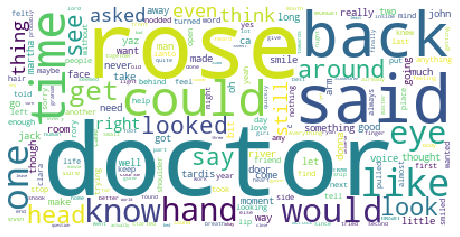

In [466]:
plt.figure(figsize=(8,6))
plt.imshow(img_lem)
plt.axis("off")

The word clouds for both lemmatizing and stemming the words look pretty much the same from a top words perspective. 

### Bigrams - Lemmatizer

In [467]:
cv_lem = CountVectorizer(ngram_range=(2,2))
counts_lem = cv_lem.fit_transform([fic_lem_flatten])

In [468]:
bgnames_l = []
bgcounts_l = []
for w in cv_lem.get_feature_names(): bgnames_l.append(w)
for c in counts_lem.toarray().flatten(): bgcounts_l.append(c)
bigrams_lem = pd.DataFrame({'word':bgnames_l,'count':bgcounts_l})

In [469]:
bigrams_lem.sort_values(ascending=False,by="count")[:50]

,word,count
947177,doctor said,10014
3662565,time lord,9231
3129410,shook head,9099
2942090,rose said,8586
741746,could see,4877
2943670,rose tyler,4789
1985037,let go,4755
2936431,rose asked,4746
1470444,gon na,4674
1269336,first time,4143


In [470]:
wc_l_bigram = WordCloud(background_color="white").generate_from_frequencies(frequencies=dict(bigrams_lem.values))

(-0.5, 399.5, 199.5, -0.5)

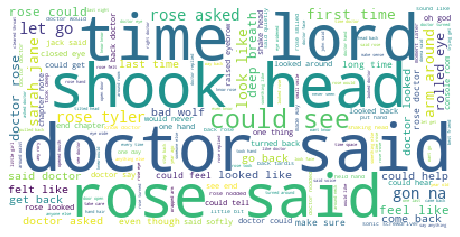

In [471]:
plt.figure(figsize=(8,6))
plt.imshow(wc_l_bigram)
plt.axis("off")

## Nouns

In [902]:
retokenize_noun = word_tokenize(noun_flatten)
mostcommon_noun = FreqDist(retokenize_noun)
mostcommon_noun.most_common(15)


[('doctor', 202338),
 ('rose', 171626),
 ('said', 103715),
 ('back', 91061),
 ('could', 82210),
 ('time', 81957),
 ('like', 78821),
 ('one', 73864),
 ('would', 71637),
 ('know', 66617),
 ('hand', 66561),
 ('eye', 65410),
 ('get', 48675),
 ('around', 45935),
 ('look', 44277)]

(-0.5, 399.5, 199.5, -0.5)

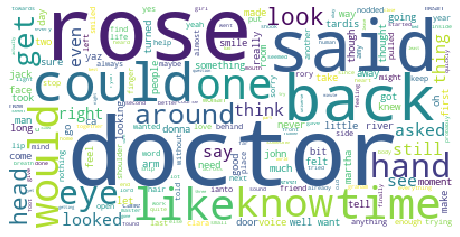

In [903]:
wc = WordCloud(background_color ="White")
img = wc.generate_from_frequencies(mostcommon_noun)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")

## Topic Modeling - First Iteration
In this first version, I just wanted to get a feel of how the topic model works and what the results are without touching any of the parameters. This will guide my process for further models.

In [930]:
cv = CountVectorizer(analyzer = 'word',max_df=0.5, min_df=25, token_pattern = '[a-zA-Z]{3,}')

In [931]:
tf_tm_l = cv.fit_transform(fic_reduced_lem.body).toarray()
tf_feature_names_tm_l = cv.get_feature_names()
model = LatentDirichletAllocation(n_components=10, random_state=0,n_jobs = -1,learning_method= 'online')
model.fit(tf_tm_l)

#online versus batch (subset versus full amount)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [532]:
#from sci-kit learn website
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

    
#https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

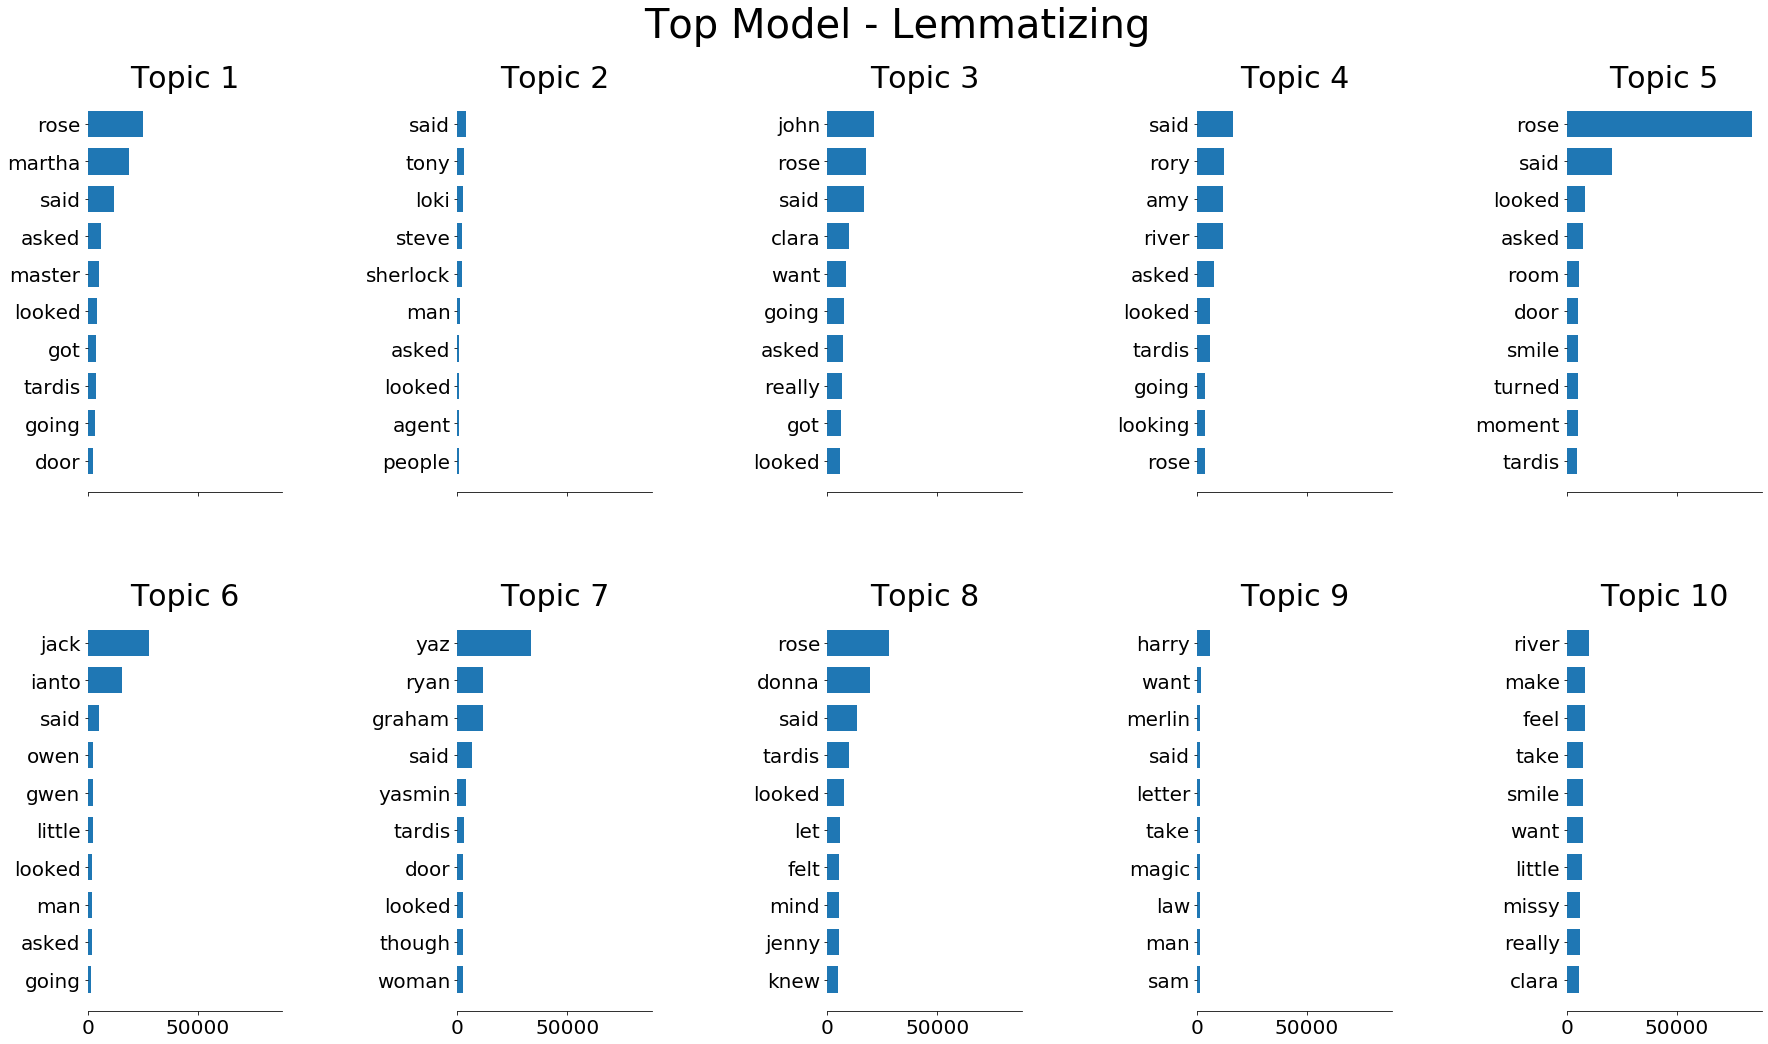

In [609]:
plot_top_words(model,tf_feature_names_tm_l,10, "Top Model - Lemmatizing" )

In [932]:
print("Log Likelihood: ", model.score(tf_tm_l))
print("Perplexity: ", model.perplexity(tf_tm_l))


Log Likelihood:  -43320793.63854103
Perplexity:  3926.571797676025


Lemmatization uses nouns only unless the POS is specified, so this first iteration only had nouns lemmatized while retaining all the other words that passed the stopwords point. I felt that nouns made more sense to include and exclude everything else.

## Tuning

Look at the words broken up by each story and understand the top words in each.

In [639]:
#Tokenize each fic but contain the words to the fic itself
wordtoken_fic = [word_tokenize(fic) for fic in fic_lem_noun.body]
freqdist_fic = [FreqDist(fic_token) for fic_token in wordtoken_fic]

In [655]:
#For the first 5 fics, the top 10 words
for x in freqdist_fic[:5]:
    print(x.most_common(10))
    print('\n')

[('harry', 1172), ('eye', 445), ('loki', 391), ('hand', 313), ('time', 255), ('voice', 230), ('something', 196), ('tony', 187), ('fury', 180), ('thor', 168)]


[('stark', 29), ('man', 21), ('clint', 19), ('hand', 15), ('eye', 12), ('wanda', 12), ('thor', 12), ('sam', 11), ('voice', 11), ('natasha', 11)]


[('rory', 41), ('coulson', 35), ('time', 21), ('something', 18), ('thing', 18), ('pandorica', 17), ('arthur', 16), ('hand', 16), ('tony', 16), ('richard', 15)]


[('time', 586), ('eye', 575), ('hand', 534), ('day', 392), ('way', 391), ('thing', 386), ('head', 381), ('something', 351), ('face', 330), ('friend', 294)]


[('doctor', 78), ('dean', 71), ('eye', 27), ('time', 25), ('thing', 21), ('something', 19), ('hand', 19), ('look', 16), ('science', 15), ('way', 14)]




In [1003]:
#Top Words from previous ngrams/model
top_words = ['doctor','time','hand','eye','head','thing','something','room'
             ,'way','jack','face','look','room','woman','man','moment','door','man'
             ,'voice','arm']

In [1004]:
#What percent of fics do these words show up in?
percent_total = []
for word in top_words:
    print("------------\nWord: " + word)
    temp = sum(1 for text in wordtoken_fic if word in text)
    print("Fic Count:{} ".format(str(temp)))
    temp2 = round((temp/1400)*100,2)
    print("Total:{}%".format(str(temp2)))
    percent_total.append(temp2)
    


------------
Word: doctor
Fic Count:1311 
Total:93.64%
------------
Word: time
Fic Count:1376 
Total:98.29%
------------
Word: hand
Fic Count:1355 
Total:96.79%
------------
Word: eye
Fic Count:1343 
Total:95.93%
------------
Word: head
Fic Count:1285 
Total:91.79%
------------
Word: thing
Fic Count:1300 
Total:92.86%
------------
Word: something
Fic Count:1306 
Total:93.29%
------------
Word: room
Fic Count:1120 
Total:80.0%
------------
Word: way
Fic Count:1307 
Total:93.36%
------------
Word: jack
Fic Count:525 
Total:37.5%
------------
Word: face
Fic Count:1305 
Total:93.21%
------------
Word: look
Fic Count:1267 
Total:90.5%
------------
Word: room
Fic Count:1120 
Total:80.0%
------------
Word: woman
Fic Count:1035 
Total:73.93%
------------
Word: man
Fic Count:1095 
Total:78.21%
------------
Word: moment
Fic Count:1233 
Total:88.07%
------------
Word: door
Fic Count:1103 
Total:78.79%
------------
Word: man
Fic Count:1095 
Total:78.21%
------------
Word: voice
Fic Count:1166 
Tot

#### Specific Model Tuning

Using different combinations of max_df and n_components, which models had the best perplexity scores?

In [1114]:
## Tuning 30%
cv = CountVectorizer(analyzer = 'word',max_df=0.3, min_df=25, token_pattern = '[a-zA-Z]{3,}')
tf_nouns = cv.fit_transform(fic_lem_noun.body).toarray()
tf_feature_names_nouns = cv.get_feature_names()

perplexity_scores = []
num_topic = [20,25,30,35]
for n in num_topic:
    model = LatentDirichletAllocation(n_components=n, random_state=0,n_jobs = -1,learning_method= 'online')
    model.fit(tf_nouns)
    perplexity_scores.append(model.perplexity(tf_nouns))
    print(n)

10
15
20
25


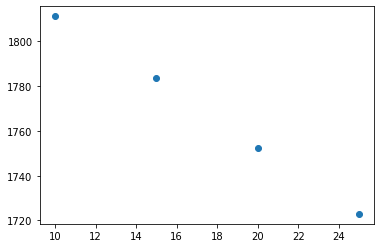

In [1115]:
plt.scatter(num_topic, perplexity_scores)

In [984]:
## Tuning 50%
cv = CountVectorizer(analyzer = 'word',max_df=0.5, min_df=25, token_pattern = '[a-zA-Z]{3,}')
tf_nouns = cv.fit_transform(fic_lem_noun.body).toarray()
tf_feature_names_nouns = cv.get_feature_names()

perplexity_scores = []
num_topic = [10,15,20,25,30,35]
for n in num_topic:
    model = LatentDirichletAllocation(n_components=n, random_state=0,n_jobs = -1,learning_method= 'online')
    model.fit(tf_nouns)
    perplexity_scores.append(model.perplexity(tf_nouns))
    print(n)

10
15
20
25
30
35


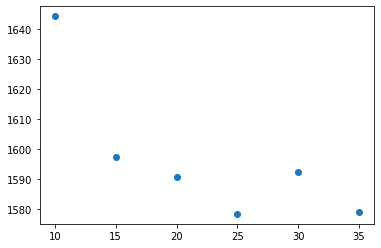

In [985]:
plt.scatter(num_topic, perplexity_scores)

In [1194]:
## Tuning 60%
cv = CountVectorizer(analyzer = 'word',max_df=0.7, min_df=25, token_pattern = '[a-zA-Z]{3,}')
tf_nouns = cv.fit_transform(fic_lem_noun.body).toarray()
tf_feature_names_nouns = cv.get_feature_names()

perplexity_scores = []
num_topic = [10,15,20,25,30,35]

for n in num_topic:
    model = LatentDirichletAllocation(n_components=n, random_state=0,n_jobs = -1,learning_method= 'online')
    model.fit(tf_nouns)
    perplexity_scores.append(model.perplexity(tf_nouns))
    print(n)


10
15
20
25
30
35


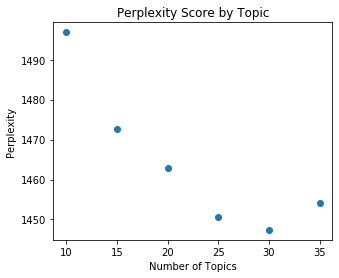

In [1264]:
plt.rcParams['figure.figsize'] = [5, 4]
plt.ylabel("Perplexity ")
plt.xlabel("Number of Topics")
plt.title("Perplexity Score by Topic")
plt.scatter(num_topic, perplexity_scores)

In [1265]:
#Best Score was 70% max_df and 30 Topics

cv = CountVectorizer(analyzer = 'word',max_df=.7, min_df=25, token_pattern = '[a-zA-Z]{3,}')
tf_nouns = cv.fit_transform(fic_lem_noun.body)
tf_feature_names_noun = cv.get_feature_names()
model = LatentDirichletAllocation(n_components = 30 ,random_state=875,n_jobs = -1,learning_method= 'online')
model.fit(tf_nouns)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=30, n_jobs=-1,
                          perp_tol=0.1, random_state=875, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [1430]:
tf_nouns.shape

(1400, 5935)

5,935 unique words used for the modeling.

In [1266]:
#Code From OurCodingClub
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [1431]:
#Top 15 words for each Topic
no_top_words = 15
topics_by_fic = display_topics(model, tf_feature_names_nouns, no_top_words)
topics_by_fic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 25 words,Topic 25 weights,Topic 26 words,Topic 26 weights,Topic 27 words,Topic 27 weights,Topic 28 words,Topic 28 weights,Topic 29 words,Topic 29 weights
0,yaz,17619.0,river,18017.9,joan,1058.3,donna,0.1,beta,173.1,...,martha,0.1,letter,1408.5,martha,13639.6,merlin,1099.1,detective,174.2
1,graham,7000.6,wife,2129.0,gallifrey,947.5,king,0.1,alpha,100.8,...,donna,0.1,law,1132.3,jack,2141.1,arthur,611.7,john,124.3
2,ryan,5301.8,song,1321.9,lord,731.3,john,0.1,sex,94.1,...,mickey,0.1,marriage,914.7,master,1552.7,reader,223.2,box,25.2
3,yasmin,1935.3,husband,434.3,smith,660.5,martha,0.1,heat,86.9,...,everyone,0.1,series,713.8,watch,949.7,everyone,150.6,watson,19.1
4,feel,1088.0,sweetie,430.8,romana,563.4,jack,0.1,gender,49.1,...,work,0.1,rejection,685.8,tim,844.3,sky,137.0,tea,19.0
5,yeah,990.4,gun,359.0,dream,549.7,body,0.1,male,46.9,...,home,0.1,anyone,429.3,family,756.7,boy,107.3,space,15.4
6,help,941.1,eyebrow,357.9,john,505.6,world,0.1,child,42.9,...,john,0.1,potter,390.0,everyone,623.9,professor,101.1,wall,12.1
7,lot,935.9,body,351.4,child,423.1,anyone,0.1,case,37.5,...,step,0.1,lot,389.4,world,612.2,carol,100.3,crack,11.9
8,chapter,925.0,century,340.9,boy,341.7,name,0.1,society,33.1,...,jane,0.1,character,389.2,work,601.4,sword,97.2,telephone,10.6
9,body,883.1,companion,332.7,son,289.8,help,0.1,presentation,32.2,...,sort,0.1,note,369.5,professor,529.1,hostess,94.0,control,8.4


### Explore

Explore the fics assigned to each topic

In [1268]:
#Export topics to CSV
topics = display_topics(model, tf_feature_names_nouns, no_top_words)
topics.to_csv(r'/Users/lcags/Documents/Practicum1/topics_' +today+'.csv'
                        ,index = False
                        ,header=True)

The below code maps each fic to the dominant topic with the highest score (or the topic that's the most similar to). Even though 30 topics were created, not every topic had a fic with it as the highest topic.

In [1269]:
#adapted from stackoverflow
#Doc to Topic Mapping
doc_topic = model.transform(tf_nouns)
doc_to_topic = pd.DataFrame(columns = ["fic","topic"])

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    doc_to_topic = doc_to_topic.append({'fic': n, 'topic': topic_most_pr}, ignore_index = True)
    

In [1464]:
#Which was the dominant topic for story number 3?
doc_topic[3].argmax()

18

In [1450]:
#No fic had the dominator topic of 3
doc_to_topic.loc[doc_to_topic["topic"] == 3]

,fic,topic


In [1437]:
#How many fics were assigned to each topic?

fics = fic_lem_noun[['work_id','title']].copy()
fics['author'] = fic_raw.author
fics['topic'] = doc_to_topic['topic']

ficcounts = fics["topic"].value_counts().reset_index()
ficcounts.columns=['topic', 'counts']


In [1438]:
pd.set_option('display.max_rows',35)
ficcounts

,topic,counts
0,18,366
1,0,176
2,14,144
3,7,137
4,21,113
5,1,77
6,23,71
7,16,51
8,20,43
9,12,43


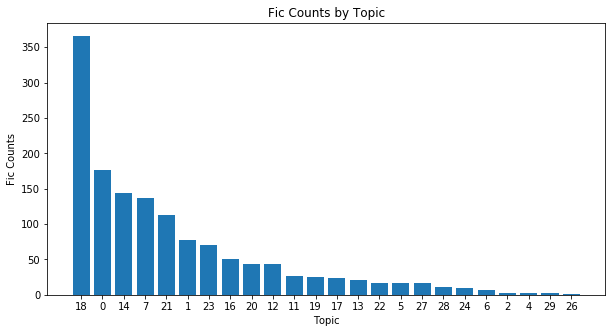

In [1379]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(range(len(ficcounts.topic)), ficcounts.counts, align='center')
plt.xticks(range(len(ficcounts.topic)), ficcounts.topic);
plt.xlabel("Topic")
plt.ylabel("Fic Counts")
plt.title("Fic Counts by Topic")

plt.show()

In [1548]:
#Top 10 Topics
top_topics = ["18","0","14","7","21","1","13","16","20","12"]
topics_by_fic.loc[:,topics_by_fic.columns.str.contains(top_topics[0])]


,Topic 18 words,Topic 18 weights
0,body,4622.1
1,foot,2844.9
2,question,2697.2
3,memory,2499.1
4,help,2471.8
5,ship,2424.0
6,mouth,2386.0
7,sort,2376.7
8,feel,2296.9
9,planet,2246.6


In [1549]:
#Explore each topics fics
fics[fics["topic"]==18]


,work_id,title,author,topic
3,12292116,My Fandom Needs Me,['Riv_ika'],18
4,609625,Past Tense,['Try2CatchMe'],18
7,6218785,Connect-the-Dots,['fingersfallingupwards'],18
9,9448043,Fantastic Humanity,['esama'],18
13,10707144,Stars Spell Out Your Name,['dls'],18
...,...,...,...,...
1376,941799,Prolonging the Inevitable,['Aeolist'],18
1379,11523594,This Reminds Me of Those RomComs Jackie Always...,['TimeLadyoftheSith'],18
1380,20424674,Reverb,['sciencebutch'],18
1385,17175596,Polyphony,['stcrmpilot'],18


## Categorizing a new Fic

Testing with the text of a new story the model hasn't seen - but has the same characteristics of the model data.

In [1353]:
new_Fic = pd.read_csv('/Users/lcags/Documents/Practicum1/new_fic1.csv', header = None)

In [1354]:
new_Fic.columns = ['work_id','title','author','rating','category','fandom','relationship','character'
                   ,'additional tags','language','published','status','status date','words'
                   ,'chapters','comments','kudos','bookmarks','hits','body']

In [1355]:
#Clean fic
new_Fic.body = html.unescape(new_Fic.body)
new_Fic.body = new_Fic.body.replace('\n', '', regex=True)
new_fic_lem = new_Fic.body.apply(clean_text_lemmatizer)
new_fic_nouns = new_fic_lem.apply(noun_only)

In [1366]:
#Clean fic
new_Fic.body = html.unescape(new_Fic.body)
new_Fic.body = new_Fic.body.replace('\n', '', regex=True)
new_fic_lem = new_Fic.body.apply(clean_text_lemmatizer)
new_fic_nouns = new_fic_lem.apply(noun_only)

#Apply Model
new_fic_tf = cv.transform(new_fic_nouns)
new_fic_topics = model.transform(new_fic_tf)

In [1376]:
#Topic this fic fits in
new_fic_topics.argmax()

7

The new fic was sorted into Topic 7

## References

Chen, Yanlin. (2018). How to generate an LDA topic model for text analysis. Retrieved from https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6<br>

Ganesan, K. (n.d.). 10+ examples for using CountVectorizer. Retrieved from https://kavita-ganesan.com/how-to-use-countvectorizer/#.YMJZGJNKgl4.

James. (n.d). Topic modeling in python. Retrieved from https://ourcodingclub.github.io/tutorials/topic-modelling-python/#apply. <br>

Li, Jingyi. (2016). AO3 scraper. Retrieved from https://github.com/radiolarian/AO3Scraper <br>

scikit-learn. (n.d.). Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation. Retrieved from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html. <br>

sophros.https://stackoverflow.com/questions/65817456/lda-topic-model-gensim-gives-same-set-of-topics<br>
    
Marcel. (2017). python scikit learn, get documents per topic in LDA. Retrieved from https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda
    